In [1]:
from scripts.make_dataset import remove_corrupted_duplicates_and_rename_images, split_dataset, crop_augment_images_for_svc, split_dataset_for_svc
from scripts.make_dataset import prepare_vit_data, prepare_svc_lr_rf_cls_features, convert_labels_to_single_class_all_splits
from scripts.build_features import build_features_svc
from scripts.model import train_yolo, train_svc_hog, predict_naive_evaluate_test_set, train_vit, train_svc_lr_rf_cls_features, evaluate_test_set
from scripts.model import predict_yolo_single_image, predict_svc_hog_single_image, predict_vit_single_image, predict_svc_lr_rf_single_image, predict_single_image

import os
import joblib
import cv2
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from ultralytics import YOLO
from transformers import ViTForImageClassification, AutoImageProcessor

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
# A. Get Dataset

# Step A1: Gather the raw dataset from Google Maps
# Gather images with metro station signages from Google Maps/Photos (approx 100 photos per station) and save them in the data/raw folder.

# List of labels/folders corresponding to YOLO class IDs (folder names have underscores while YOLO class IDs do not)
label_map = {
    0: 'Chong_Nonsi', 
    1: 'National_Stadium',
    2: 'Ratchadamri', 
    3: 'Saint_Louis', 
    4: 'Sala_Daeng', 
    5: 'Saphan_Taksin', 
    6: 'Siam', 
    7: 'Surasak'
}

# List of station folder names corresponding to the 8 stations in the BTS Silom Line (Dark Green Line without extension)
station_folder_name = list(label_map.values())

# station_folder_name = [
#     "Siam",
#     "National_Stadium", 
#     "Ratchadamri", 
#     "Sala_Daeng", 
#     "Chong_Nonsi", 
#     "Saint_Louis", 
#     "Surasak", 
#     "Saphan_Taksin"
# ]

# Step A2: Remove corrupted images, duplicates, and rename images, then save them in the data/processed_before_roboflow folder
# This step was done before uploading to Roboflow, so it should be commented out if the annotated dataset exported from Roboflow is ready for the next step.
remove_corrupted_duplicates_and_rename_images(station_folder_name)

# Step A3: Upload the dataset to Roboflow, annotate the images, draw bounding boxes manually, and then export the dataset in YOLO format.
# Put the exported dataset in the data/processed folder.

Duplicate: data\raw\National_Stadium\National-Stadium-Google-Maps(13).png
Duplicate: data\raw\National_Stadium\National-Stadium-Google-Maps(18).png
Duplicate: data\raw\National_Stadium\National-Stadium-Google-Maps(37).png
Duplicate: data\raw\National_Stadium\National-Stadium-Google-Maps(38).png
Duplicate: data\raw\National_Stadium\National-Stadium-Google-Maps(39).png
Duplicate: data\raw\National_Stadium\National-Stadium-Google-Maps(44).png
Duplicate: data\raw\National_Stadium\National-Stadium-Google-Maps(45).png
Duplicate: data\raw\National_Stadium\National-Stadium-Google-Maps(53).png
Duplicate: data\raw\National_Stadium\National-Stadium-Google-Maps(55).png
Duplicate: data\raw\National_Stadium\National-Stadium-Google-Maps(59).png
Duplicate: data\raw\National_Stadium\National-Stadium-Google-Maps(62).png
Duplicate: data\raw\National_Stadium\National-Stadium-Google-Maps(63).png
Duplicate: data\raw\National_Stadium\National-Stadium-Google-Maps(65).png
Duplicate: data\raw\National_Stadium\N

In [3]:
# Step A4: Split the dataset into training, validation, and test sets, then save them in the data/outputs folder.
split_dataset(station_folder_name)

Stratified split complete.


In [ ]:
# Step A5: Crop the images in the training, validation, and test sets to create a new dataset with only the metro station signage. This is for the SVC model.
crop_augment_images_for_svc(label_map)

[train] Extracted 1059 cropped signage images.
[train] Skipped images (too small):
  Chong_Nonsi: 3 skipped
  National_Stadium: 8 skipped
  Ratchadamri: 6 skipped
  Saint_Louis: 3 skipped
  Sala_Daeng: 8 skipped
  Saphan_Taksin: 0 skipped
  Siam: 7 skipped
  Surasak: 2 skipped
[valid] Extracted 129 cropped signage images.
[valid] Skipped images (too small):
  Chong_Nonsi: 0 skipped
  National_Stadium: 2 skipped
  Ratchadamri: 2 skipped
  Saint_Louis: 0 skipped
  Sala_Daeng: 1 skipped
  Saphan_Taksin: 0 skipped
  Siam: 0 skipped
  Surasak: 0 skipped
[test] Extracted 139 cropped signage images.
[test] Skipped images (too small):
  Chong_Nonsi: 0 skipped
  National_Stadium: 0 skipped
  Ratchadamri: 1 skipped
  Saint_Louis: 1 skipped
  Sala_Daeng: 0 skipped
  Saphan_Taksin: 0 skipped
  Siam: 3 skipped
  Surasak: 1 skipped


In [2]:
# Step A6: Build features and labels for SVC model
features_by_split, labels_by_split = build_features_svc()

[RESULT] train: 6354 samples
[RESULT] valid: 774 samples
[RESULT] test: 834 samples


In [3]:
# Step A7: Prepare the training and test data for SVC + HOG model
svc_X_train_full_scaled, svc_y_train_full, svc_X_test_scaled, svc_y_test, hog_scaler = split_dataset_for_svc(features_by_split, labels_by_split)

In [5]:
# Step A8: Copy YOLO multi-label training data and convert it into single-label.
convert_labels_to_single_class_all_splits()

In [5]:
# Step A9: Prepare data for Vision Transformer Model training.
dataset, id2label, label2id, inference_transform, processor = prepare_vit_data()

Resolving data files:   0%|          | 0/6354 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/774 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/834 [00:00<?, ?it/s]

In [2]:
# B. Train models

# Step B1: Train YOLOv8 model [Multi-label] for detecting Bangkok Metro Station Signage
best_yolo_model_multi_labels, yolo_metrics_multi_labels = train_yolo(epochs=100, img_size=960, batchsize=16, device='cuda', single_label=False)

New https://pypi.org/project/ultralytics/8.3.174 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.173  Python-3.10.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data\outputs_multi_labels\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=training_results, nbs=64

c:\Users\beung-yoga\Documents\GitHub4\.venv\lib\site-packages\torch\nn\modules\module.py:1329: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


AMP: checks passed 
train: Fast image access  (ping: 0.00.0 ms, read: 1208.6481.6 MB/s, size: 131.8 KB)


train: Scanning C:\Users\beung-yoga\Documents\GitHub4\final-project\data\outputs_multi_labels\train\labels.cache... 704 images, 0 backgrounds, 0 corrupt: 100%|██████████| 704/704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 528.9247.3 MB/s, size: 108.8 KB)


val: Scanning C:\Users\beung-yoga\Documents\GitHub4\final-project\data\outputs_multi_labels\valid\labels.cache... 89 images, 0 backgrounds, 0 corrupt: 100%|██████████| 89/89 [00:00<?, ?it/s]


Plotting labels to models\deep_learning_yolo_multi_labels\training_results\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 960 train, 960 val
Using 8 dataloader workers
Logging results to models\deep_learning_yolo_multi_labels\training_results
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       7.6G      1.363      14.26      1.471         52        960: 100%|██████████| 44/44 [00:27<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

                   all         89        134       0.56     0.0812     0.0913     0.0719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.38G      1.034      3.329      1.202         31        960: 100%|██████████| 44/44 [00:26<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         89        134     0.0963      0.138     0.0908     0.0675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.38G      0.998      2.697      1.178         45        960: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all         89        134       0.13      0.148     0.0813     0.0612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.42G      1.041      2.443      1.182         40        960: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134      0.195      0.213      0.149      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.38G      1.033      2.326       1.19         46        960: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

                   all         89        134       0.21      0.335      0.218      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.38G     0.9961       2.24      1.165         38        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134      0.353      0.372      0.294      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.38G     0.9412      2.056      1.129         42        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         89        134      0.244      0.296      0.236       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.36G     0.8987      1.926       1.11         36        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         89        134       0.22      0.411      0.308      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.38G     0.8729      1.852      1.096         52        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         89        134      0.289       0.45      0.342      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.38G     0.8617      1.715      1.079         34        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         89        134      0.391      0.333      0.385      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.38G     0.8468      1.672       1.08         39        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         89        134      0.298      0.409      0.367      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.38G      0.862      1.642        1.1         33        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         89        134      0.393      0.456      0.412      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.38G      0.844      1.599      1.102         35        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         89        134      0.336      0.481      0.445      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.38G     0.7969      1.532      1.059         32        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134      0.566      0.391      0.501      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.38G     0.7875      1.482      1.048         45        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134      0.352      0.554      0.475      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.38G     0.7457      1.382      1.036         40        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         89        134      0.446      0.512      0.519      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.38G     0.7405      1.339      1.038         34        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         89        134       0.61      0.467      0.549      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.38G     0.7471      1.323      1.034         48        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         89        134      0.581      0.583      0.621      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.38G     0.7314      1.206       1.02         34        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         89        134      0.561      0.718      0.632      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.38G     0.7151      1.143      1.007         21        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         89        134      0.651       0.48      0.614      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.38G     0.7028      1.191      1.024         40        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         89        134      0.515      0.656       0.61      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.38G     0.6987      1.138      1.017         49        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         89        134      0.616       0.61      0.648      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.38G     0.6841      1.083      1.007         38        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         89        134      0.695      0.613      0.683      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.38G     0.6929      1.068     0.9902         38        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         89        134      0.611      0.627      0.638      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.38G     0.6747      1.004     0.9805         29        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         89        134       0.61      0.694      0.702      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.38G     0.6519     0.9798     0.9704         29        960: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134      0.597      0.606       0.65      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.38G     0.6634     0.9833     0.9942         45        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         89        134      0.584      0.674      0.674      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.38G     0.6745     0.9885      1.004         32        960: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         89        134       0.71      0.622      0.666      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.38G     0.6383     0.9367     0.9795         31        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         89        134      0.617        0.6       0.67      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.38G      0.614     0.9035     0.9686         32        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134      0.649       0.65      0.673      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.38G     0.6314     0.8814     0.9746         39        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         89        134      0.686      0.658      0.718      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.38G     0.6218     0.8465     0.9764         31        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         89        134       0.68      0.712      0.744      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.38G     0.6044     0.8155      0.949         38        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         89        134      0.704       0.62      0.722      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.42G      0.615     0.7573     0.9519         41        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         89        134      0.779      0.637      0.763      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.38G     0.6225     0.7757     0.9633         43        960: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         89        134      0.781      0.673      0.759      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.38G     0.6009     0.7556     0.9447         36        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         89        134       0.66      0.662      0.742       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.38G      0.574     0.7501     0.9415         39        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         89        134      0.747      0.732      0.787      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.38G     0.6052      0.795     0.9592         34        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         89        134      0.755      0.745      0.774      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.38G      0.579     0.7475     0.9544         33        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         89        134      0.835      0.636      0.797      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.38G     0.5705     0.7069     0.9481         37        960: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         89        134      0.758      0.648      0.753      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.38G     0.5687     0.7298     0.9365         41        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         89        134      0.804      0.686      0.783       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.38G      0.564     0.7323     0.9327         30        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         89        134      0.761       0.73       0.76      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.38G     0.5583     0.7017     0.9431         44        960: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]

                   all         89        134      0.854      0.729      0.816      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.38G     0.5434     0.6554     0.9247         33        960: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         89        134      0.735      0.732      0.784      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.42G     0.5523     0.6562     0.9399         33        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         89        134      0.867       0.77      0.862      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.38G     0.5422     0.6619     0.9298         28        960: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         89        134      0.771      0.726      0.819      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.38G     0.5385     0.6623     0.9256         45        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         89        134      0.779      0.726      0.782      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.38G     0.5251     0.6284     0.9211         24        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         89        134      0.784      0.771       0.83       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.38G      0.536      0.667     0.9227         34        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         89        134      0.742      0.771      0.779      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.38G     0.5342     0.6212     0.9154         63        960: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         89        134      0.817      0.706      0.799      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.38G     0.5254     0.6073     0.9128         25        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         89        134      0.899      0.738      0.848      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.38G     0.5062     0.5807     0.8979         38        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         89        134      0.876        0.7      0.851      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.38G     0.5186     0.5993     0.9127         42        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         89        134      0.856      0.758      0.848      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.38G     0.5044     0.6028     0.9157         44        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134      0.828       0.74      0.838      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.38G     0.4954     0.5852     0.9025         38        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         89        134      0.919      0.731      0.875      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.38G     0.5095     0.5685     0.9186         41        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         89        134      0.795      0.752      0.823      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.38G     0.4844     0.5389     0.8946         42        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134      0.874      0.659      0.814      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.38G     0.5015     0.5862     0.9057         38        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134      0.841      0.729      0.846       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.38G     0.4914     0.5406     0.9042         24        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         89        134      0.878      0.695      0.846      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.38G     0.4718     0.5394     0.8909         32        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         89        134      0.815      0.731      0.808      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.38G     0.4886     0.5391     0.8988         41        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         89        134      0.858      0.715      0.816      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.38G     0.4741     0.5321     0.8968         29        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         89        134      0.855      0.681      0.824      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.38G     0.4838     0.5181     0.8981         39        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         89        134      0.817       0.74       0.81      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.38G     0.4648     0.5314     0.8907         45        960: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134      0.901      0.737      0.834      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.38G      0.458     0.5042     0.8858         26        960: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         89        134       0.86      0.745      0.828      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.38G     0.4641     0.4951     0.8876         29        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         89        134      0.859       0.77      0.839      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.38G     0.4659     0.5084     0.8909         38        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         89        134      0.905      0.749      0.865      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.38G     0.4582     0.4928     0.8882         40        960: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         89        134      0.859      0.794      0.872      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.38G     0.4687     0.4958     0.8946         49        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         89        134      0.894      0.751       0.87      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.38G     0.4321     0.4598     0.8761         40        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         89        134      0.938      0.742      0.871      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.38G     0.4443      0.461     0.8808         39        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         89        134      0.872       0.79      0.864      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.42G     0.4424      0.462     0.8871         58        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         89        134      0.929       0.78      0.886      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.38G     0.4342     0.4402     0.8834         39        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         89        134      0.971      0.753      0.886      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.38G     0.4254     0.4527     0.8806         32        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134      0.874      0.796      0.874      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.38G     0.4252     0.4391     0.8811         35        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134      0.925      0.815        0.9      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.38G     0.4214      0.424     0.8706         24        960: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         89        134      0.924      0.742      0.874      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.38G      0.431     0.4614     0.8807         33        960: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         89        134      0.915      0.811      0.882      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.38G     0.4158     0.4354     0.8823         40        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         89        134      0.885      0.796      0.875      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.38G     0.4269     0.4476     0.8754         44        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         89        134      0.868      0.836      0.878       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.38G     0.4047     0.4072     0.8683         53        960: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         89        134      0.891      0.788      0.862      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.38G     0.4181     0.4245     0.8685         35        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         89        134       0.95      0.754      0.874      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.38G     0.4032     0.3988     0.8718         34        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         89        134      0.911      0.764      0.868        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.38G     0.3844     0.4001     0.8679         46        960: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         89        134      0.908      0.777      0.859      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.38G     0.3833     0.3921     0.8629         40        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         89        134      0.911      0.763      0.863      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.38G     0.3989     0.3928     0.8685         34        960: 100%|██████████| 44/44 [00:26<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         89        134      0.924        0.8      0.884      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.38G      0.395     0.4099     0.8672         36        960: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         89        134      0.915      0.808      0.891      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.38G     0.3907     0.4007     0.8691         38        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         89        134      0.956      0.763       0.88      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.38G     0.3861     0.3948     0.8734         41        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         89        134      0.957      0.749      0.875      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.38G      0.371     0.3623     0.8452         37        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         89        134      0.946      0.794      0.882      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.38G     0.3783     0.3936     0.8671         28        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all         89        134      0.884      0.791      0.863      0.802


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.38G     0.3592     0.3245     0.8487         22        960: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]

                   all         89        134      0.876      0.795      0.868      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.38G     0.3427     0.3121     0.8232         25        960: 100%|██████████| 44/44 [00:25<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         89        134      0.906      0.778      0.868      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.38G      0.338     0.3114     0.8227         21        960: 100%|██████████| 44/44 [00:26<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         89        134      0.927       0.77      0.881      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.38G     0.3363     0.3018     0.8254         23        960: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         89        134      0.851      0.813      0.882      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.38G      0.339     0.3042     0.8205         22        960: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134      0.934      0.763      0.881      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.38G     0.3316     0.3081     0.8263         23        960: 100%|██████████| 44/44 [00:26<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         89        134      0.921      0.788      0.892      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.38G      0.332     0.2933     0.8279         23        960: 100%|██████████| 44/44 [00:26<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         89        134      0.936      0.745      0.872      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      7.38G     0.3306     0.2917     0.8214         22        960: 100%|██████████| 44/44 [00:26<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134      0.944      0.758      0.883      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.38G     0.3328     0.2977     0.8299         27        960: 100%|██████████| 44/44 [00:26<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         89        134      0.953      0.762      0.884      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.38G     0.3259     0.2978     0.8318         23        960: 100%|██████████| 44/44 [00:26<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         89        134      0.938       0.77      0.884      0.819



100 epochs completed in 0.801 hours.
Optimizer stripped from models\deep_learning_yolo_multi_labels\training_results\weights\last.pt, 22.6MB
Optimizer stripped from models\deep_learning_yolo_multi_labels\training_results\weights\best.pt, 22.6MB

Validating models\deep_learning_yolo_multi_labels\training_results\weights\best.pt...
Ultralytics 8.3.173  Python-3.10.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


                   all         89        134      0.929      0.854      0.914      0.846
           Chong Nonsi          7          9      0.738      0.778      0.839      0.789
      National Stadium         14         22      0.874      0.955      0.955       0.87
           Ratchadamri         10         19      0.941      0.845      0.921      0.877
           Saint Louis          6          9      0.976      0.889       0.89       0.83
            Sala Daeng         15         23      0.935      0.913      0.928      0.846
         Saphan Taksin         17         22          1      0.704      0.844      0.792
                  Siam         15         22      0.969      0.909      0.953      0.862
               Surasak          5          8          1      0.837      0.982        0.9
Speed: 0.5ms preprocess, 29.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to models\deep_learning_yolo_multi_labels\training_results
Ultralytics 8.3.173  Python-3.10.11 torch-2

val: Scanning C:\Users\beung-yoga\Documents\GitHub4\final-project\data\outputs_multi_labels\test\labels.cache... 89 images, 0 backgrounds, 0 corrupt: 100%|██████████| 89/89 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


                   all         89        145      0.832      0.839      0.867      0.779
           Chong Nonsi          6          8       0.49      0.875      0.721      0.634
      National Stadium         14         21      0.951      0.917      0.987      0.896
           Ratchadamri         10         19      0.841      0.895      0.927       0.84
           Saint Louis          7         12      0.725      0.882      0.814      0.743
            Sala Daeng         15         23      0.884      0.783      0.871      0.791
         Saphan Taksin         14         20       0.94       0.79       0.88      0.807
                  Siam         15         26      0.915      0.824      0.896       0.76
               Surasak          8         16      0.912       0.75      0.841      0.761
Speed: 4.3ms preprocess, 43.1ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to models\deep_learning_yolo_multi_labels\test_results
ultralytics.utils.metrics.DetMetrics object wit

c:\Users\beung-yoga\Documents\GitHub4\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\beung-yoga\Documents\GitHub4\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\beung-yoga\Documents\GitHub4\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



0: 960x960 2 Siams, 84.2ms
Speed: 7.0ms preprocess, 84.2ms inference, 1.9ms postprocess per image at shape (1, 3, 960, 960)
Results saved to data\demo_predictions6


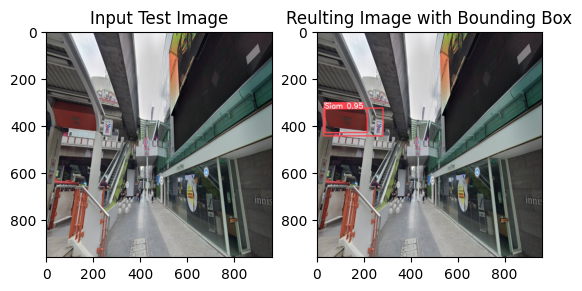

Predicted Station Names: Siam


In [34]:
# Test the YOLOv8 model with one image from the test set
best_yolo_model_multi_labels_path = os.path.join("models", "deep_learning_yolo_multi_labels", "best.pt")
best_yolo_model_multi_labels = YOLO(best_yolo_model_multi_labels_path)

# Load the image
input_test_image_path = os.path.join("data", "outputs_multi_labels", "test", "images", "Siam_001_png.rf.ea48fca9fc87c689e62db2f87c4e9df4.jpg")
input_test_img = cv2.imread(input_test_image_path)
# Convert the image to RGB
input_test_image = cv2.cvtColor(input_test_img, cv2.COLOR_BGR2RGB)

station_names_unique, new_resulting_image_path = predict_yolo_single_image(best_yolo_model_multi_labels, input_test_img)

# Load the image
output_image_path = os.path.join(new_resulting_image_path)
output_img = cv2.imread(output_image_path)
# Convert the image to RGB
output_image = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)

# Display the images
%matplotlib inline
plt.subplot(121)
plt.title('Input Test Image')
plt.imshow(input_test_image)
plt.subplot(122)
plt.title('Reulting Image with Bounding Box')
plt.imshow(output_image)
plt.show()

if station_names_unique:
    print(f"Predicted Station Names: {station_names_unique[0]}")
else:
    print("No station detected.")

In [2]:
# Step B2: Train YOLOv8 model [Single-label] for detecting Bangkok Metro Station Signage
best_yolo_model_single_label, yolo_metrics_single_label = train_yolo(epochs=100, img_size=960, batchsize=16, device='cuda', single_label=True)

New https://pypi.org/project/ultralytics/8.3.174 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.173  Python-3.10.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data\outputs_single_label\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=training_results, nbs=64

c:\Users\beung-yoga\Documents\GitHub4\.venv\lib\site-packages\torch\nn\modules\module.py:1329: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


AMP: checks passed 
train: Fast image access  (ping: 0.10.0 ms, read: 181.531.0 MB/s, size: 131.8 KB)


train: Scanning C:\Users\beung-yoga\Documents\GitHub4\final-project\data\outputs_single_label\train\labels.cache... 704 images, 0 backgrounds, 0 corrupt: 100%|██████████| 704/704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 167.558.5 MB/s, size: 108.8 KB)


val: Scanning C:\Users\beung-yoga\Documents\GitHub4\final-project\data\outputs_single_label\valid\labels.cache... 89 images, 0 backgrounds, 0 corrupt: 100%|██████████| 89/89 [00:00<?, ?it/s]


Plotting labels to models\deep_learning_yolo_single_label\training_results\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 960 train, 960 val
Using 8 dataloader workers
Logging results to models\deep_learning_yolo_single_label\training_results
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.58G      1.351      6.276      1.431         52        960: 100%|██████████| 44/44 [00:28<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134       0.15      0.246       0.11     0.0622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.35G      1.312      2.021      1.391         31        960: 100%|██████████| 44/44 [00:27<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         89        134      0.126      0.142     0.0651     0.0308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.37G      1.366      1.717      1.425         45        960: 100%|██████████| 44/44 [00:26<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         89        134     0.0398      0.104     0.0104    0.00303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       7.4G      1.426      1.599      1.452         40        960: 100%|██████████| 44/44 [00:26<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         89        134      0.127     0.0821     0.0541     0.0299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.36G      1.331      1.529      1.375         46        960: 100%|██████████| 44/44 [00:26<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         89        134      0.486      0.291      0.306       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.35G        1.3      1.413      1.359         38        960: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134      0.617      0.373      0.377      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.35G       1.21      1.253      1.302         42        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134      0.528      0.448      0.485      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.35G      1.169      1.231      1.272         36        960: 100%|██████████| 44/44 [00:26<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         89        134      0.766      0.567      0.648      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.35G      1.111      1.172      1.241         52        960: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         89        134      0.768      0.582        0.7      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.36G      1.077      1.096      1.197         34        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134      0.775      0.643      0.731      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.35G      1.052      1.032        1.2         39        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         89        134      0.834      0.776      0.813       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.35G      1.057      1.006      1.216         33        960: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         89        134      0.833      0.627      0.751      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.35G      1.015      0.977      1.194         35        960: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         89        134      0.795      0.784      0.822        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.35G     0.9672     0.9486      1.165         32        960: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134      0.866      0.716      0.808       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.35G     0.9579     0.9097      1.168         45        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all         89        134      0.779      0.739      0.788      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.35G     0.9434      0.889      1.138         40        960: 100%|██████████| 44/44 [00:26<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         89        134      0.755      0.758      0.778      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.35G     0.9322     0.8607      1.128         34        960: 100%|██████████| 44/44 [00:26<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         89        134      0.838      0.774      0.807      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.35G      0.911     0.8495      1.119         48        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         89        134      0.868      0.784      0.854      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.35G     0.8787     0.7938      1.097         34        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all         89        134      0.841       0.75      0.821       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.35G     0.8533     0.7825      1.078         21        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         89        134      0.926      0.769      0.884      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.35G     0.8563     0.7851      1.085         40        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         89        134       0.81      0.806      0.864      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.35G     0.8505     0.7832      1.088         49        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         89        134      0.765      0.802      0.846      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.35G     0.8126     0.7504      1.066         38        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         89        134      0.788      0.754      0.826      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.35G     0.8044     0.7425       1.04         38        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134      0.864      0.805      0.873      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.35G     0.7879     0.7015      1.037         29        960: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         89        134      0.867      0.777      0.871      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.35G     0.7703     0.6982      1.036         29        960: 100%|██████████| 44/44 [00:27<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

                   all         89        134      0.882      0.821      0.893      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.35G      0.785     0.6893      1.054         45        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         89        134      0.885      0.828      0.892      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.35G     0.7873     0.6888      1.052         32        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         89        134      0.885      0.813      0.901      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.35G     0.7461     0.6794      1.024         31        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         89        134      0.886       0.81      0.912      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.35G     0.7395     0.6644      1.028         32        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         89        134      0.832      0.849      0.877      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.35G     0.7397     0.6585      1.029         39        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         89        134      0.864      0.806      0.884      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.35G     0.7278     0.6579      1.021         31        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         89        134      0.911      0.858      0.915      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.35G     0.7092     0.6348      1.002         38        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         89        134      0.879      0.828      0.879      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100       7.4G     0.7205     0.6313      1.011         41        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         89        134      0.886      0.809      0.866      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.35G     0.7256     0.6103      1.009         43        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         89        134      0.889      0.866      0.917      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.35G     0.7055     0.6107     0.9861         36        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         89        134      0.965      0.819      0.908      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.35G     0.6722     0.5778     0.9843         39        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         89        134      0.955      0.843       0.93      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.35G     0.6837     0.5993     0.9971         34        960: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         89        134      0.928      0.828      0.903      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.35G     0.6815      0.612      1.004         33        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         89        134      0.931      0.806      0.887      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.35G     0.6766     0.5773     0.9977         37        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         89        134      0.885      0.851       0.91      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.35G     0.6789     0.5989       0.99         41        960: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         89        134      0.945      0.821      0.908      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.35G     0.6617     0.5754     0.9754         30        960: 100%|██████████| 44/44 [00:26<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         89        134      0.935      0.866      0.927      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.35G     0.6537     0.5623     0.9766         44        960: 100%|██████████| 44/44 [00:26<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         89        134       0.89      0.848      0.917      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.35G     0.6517     0.5626     0.9656         33        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         89        134      0.928      0.869      0.924      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.39G     0.6575     0.5759     0.9783         33        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         89        134      0.935      0.836      0.912      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.35G     0.6468     0.5505     0.9766         28        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         89        134      0.937      0.843       0.91       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.35G     0.6196     0.5347     0.9586         45        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         89        134      0.899      0.863      0.903       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.35G     0.6225     0.5267     0.9655         24        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all         89        134      0.928       0.87      0.937      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.35G     0.6352     0.5457     0.9683         34        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         89        134      0.987      0.836      0.929      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.35G      0.637     0.5246     0.9681         63        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         89        134      0.944      0.875      0.925      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.35G     0.6041      0.521     0.9489         25        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

                   all         89        134      0.937      0.858      0.915      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.35G      0.606     0.5111     0.9421         38        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         89        134      0.943      0.866      0.922      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.35G     0.6033     0.5168     0.9466         42        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         89        134      0.928      0.869      0.929      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.35G     0.5923     0.5129     0.9485         44        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         89        134      0.949      0.834       0.92      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.36G     0.5797     0.4949     0.9434         38        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         89        134      0.907      0.888      0.913      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.35G     0.5915     0.5111     0.9614         41        960: 100%|██████████| 44/44 [00:26<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         89        134      0.871      0.881      0.898      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.35G     0.5733     0.4879     0.9352         42        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]

                   all         89        134      0.889      0.873      0.912      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.35G     0.5821     0.4892     0.9417         38        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134      0.943      0.828      0.907       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.35G     0.5651     0.4828     0.9382         24        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         89        134      0.913      0.863      0.917      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.35G     0.5575     0.4685     0.9232         32        960: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         89        134      0.939      0.866      0.925      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.35G     0.5779     0.4806     0.9412         41        960: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         89        134      0.982      0.866      0.907      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.35G      0.555     0.4694     0.9316         29        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         89        134      0.966      0.859      0.919      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.35G     0.5447     0.4566     0.9247         39        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         89        134      0.905      0.888      0.903      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.35G     0.5271     0.4533     0.9216         45        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         89        134      0.945      0.866      0.925      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.35G     0.5471      0.452     0.9207         26        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         89        134      0.958      0.851      0.927      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.35G     0.5297     0.4413     0.9225         29        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         89        134       0.93      0.886       0.93      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.35G       0.54      0.461     0.9232         38        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         89        134      0.975      0.859      0.923      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.35G     0.5221     0.4354     0.9151         40        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         89        134      0.976      0.858      0.929      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.35G     0.5371     0.4384     0.9228         49        960: 100%|██████████| 44/44 [00:26<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         89        134      0.959      0.867      0.927      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.35G     0.5107     0.4335     0.9123         40        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134      0.969      0.866      0.929      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.35G     0.5067     0.4228     0.9059         39        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         89        134      0.946      0.866      0.921      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.39G     0.5006     0.4123     0.9129         58        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         89        134      0.962      0.858      0.924      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.35G     0.4991     0.4224     0.9112         39        960: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134      0.891      0.914      0.917      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.35G     0.4856     0.4088     0.9046         32        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         89        134      0.901       0.91      0.929       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.35G      0.493     0.3944     0.9051         35        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         89        134      0.943       0.87      0.921      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.35G       0.49     0.3966     0.8965         24        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         89        134      0.958      0.858      0.914      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.36G     0.4978     0.4229     0.9084         33        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         89        134      0.955      0.873      0.922      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.35G     0.4912     0.4074     0.9142         40        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         89        134       0.96      0.888      0.936      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.35G     0.5022     0.4148     0.9059         44        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         89        134      0.949      0.918       0.93      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.35G     0.4663     0.3967     0.8918         53        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         89        134      0.964      0.866      0.928      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.35G     0.4804     0.4148     0.8912         35        960: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

                   all         89        134      0.951      0.896       0.93      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.35G     0.4654     0.3866     0.8958         34        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134      0.923      0.895      0.934      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.35G     0.4396     0.3749     0.8906         46        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         89        134      0.957      0.873       0.93      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.35G     0.4498     0.3721     0.8846         40        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         89        134      0.971      0.896      0.935      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.35G     0.4488     0.3692     0.8898         34        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         89        134      0.959      0.882       0.94      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.35G     0.4508     0.3868      0.891         36        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         89        134      0.983       0.86      0.936      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.35G     0.4481     0.3871      0.891         38        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134       0.98      0.873      0.933      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.35G     0.4297     0.3611     0.8926         41        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         89        134      0.962      0.858      0.925      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.35G     0.4209     0.3555     0.8706         37        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         89        134      0.991      0.848      0.931      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.35G     0.4406     0.3621     0.8918         28        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         89        134       0.98      0.866      0.928      0.849


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.36G     0.4118     0.3268     0.8723         22        960: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

                   all         89        134       0.96      0.898      0.931      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.35G     0.3898      0.312     0.8429         25        960: 100%|██████████| 44/44 [00:26<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         89        134      0.966      0.888      0.928      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.36G      0.394     0.3159      0.847         21        960: 100%|██████████| 44/44 [00:25<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         89        134      0.968      0.909      0.938      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.35G     0.3794     0.3071     0.8454         23        960: 100%|██████████| 44/44 [00:26<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         89        134      0.975      0.864      0.939       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.35G     0.3901     0.3086     0.8457         22        960: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         89        134      0.967      0.875      0.937       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.35G      0.379     0.3065      0.847         23        960: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         89        134      0.964      0.873      0.936      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.36G     0.3708      0.301     0.8436         23        960: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         89        134      0.966      0.866      0.931      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      7.36G     0.3678     0.2962     0.8397         22        960: 100%|██████████| 44/44 [00:26<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

                   all         89        134      0.983      0.858      0.936      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.35G      0.376     0.2979     0.8444         27        960: 100%|██████████| 44/44 [00:26<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         89        134      0.929      0.888      0.928       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.35G     0.3688     0.2949     0.8487         23        960: 100%|██████████| 44/44 [00:26<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         89        134      0.938      0.903      0.944       0.86



100 epochs completed in 0.798 hours.
Optimizer stripped from models\deep_learning_yolo_single_label\training_results\weights\last.pt, 22.6MB
Optimizer stripped from models\deep_learning_yolo_single_label\training_results\weights\best.pt, 22.6MB

Validating models\deep_learning_yolo_single_label\training_results\weights\best.pt...
Ultralytics 8.3.173  Python-3.10.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


                   all         89        134      0.945      0.866      0.936      0.858
Speed: 0.4ms preprocess, 28.9ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to models\deep_learning_yolo_single_label\training_results
Ultralytics 8.3.173  Python-3.10.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 214.023.2 MB/s, size: 107.8 KB)


val: Scanning C:\Users\beung-yoga\Documents\GitHub4\final-project\data\outputs_single_label\test\labels.cache... 89 images, 0 backgrounds, 0 corrupt: 100%|██████████| 89/89 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


                   all         89        145      0.932      0.848      0.927       0.84
Speed: 2.2ms preprocess, 44.1ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to models\deep_learning_yolo_single_label\test_results
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002497963B910>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.030

c:\Users\beung-yoga\Documents\GitHub4\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\beung-yoga\Documents\GitHub4\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\beung-yoga\Documents\GitHub4\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
# Step B3: Train Vision Transformer Model
best_vit_model, vit_test_accuracy = train_vit(dataset, id2label, label2id)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
50,1.685700,1.436740,0.521964
100,0.941500,0.928251,0.686047
150,0.494100,0.634844,0.784238
200,0.285300,0.488135,0.841085
250,0.188300,0.381535,0.868217
300,0.118200,0.254500,0.908269
350,0.078200,0.250509,0.908269
400,0.035300,0.294410,0.891473
450,0.031700,0.378333,0.904393
500,0.026000,0.300117,0.904393


Metrics: {'test_loss': 0.1614425629377365, 'test_accuracy': 0.9640287769784173, 'test_runtime': 9.4894, 'test_samples_per_second': 87.888, 'test_steps_per_second': 5.585}

Test Accuracy: 0.964029
Classification Report:
                   precision    recall  f1-score   support

     Chong_Nonsi       0.88      0.94      0.91        48
National_Stadium       0.95      0.98      0.96       126
     Ratchadamri       0.97      0.98      0.98       108
     Saint_Louis       1.00      0.86      0.93        66
      Sala_Daeng       0.99      0.99      0.99       138
   Saphan_Taksin       0.92      0.91      0.92       120
            Siam       0.99      1.00      1.00       138
         Surasak       0.98      1.00      0.99        90

        accuracy                           0.96       834
       macro avg       0.96      0.96      0.96       834
    weighted avg       0.96      0.96      0.96       834

Confusion Matrix:
 [[ 45   0   0   0   0   3   0   0]
 [  3 123   0   0   0   0  

Predicted Station: Chong Nonsi


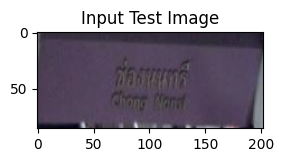

In [7]:
best_vit_model_path = os.path.join("models", "deep_learning_vit", "checkpoint-1990")
best_vit_model = ViTForImageClassification.from_pretrained(best_vit_model_path)

input_test_image_path = os.path.join("data", "outputs_multi_labels", "test", "crops", "Chong_Nonsi", "crop_7.jpg")
input_test_img = cv2.imread(input_test_image_path)
# Convert the image to RGB
input_test_image = cv2.cvtColor(input_test_img, cv2.COLOR_BGR2RGB)

predicted_station = predict_vit_single_image(best_vit_model, inference_transform, id2label, input_test_image_path)

if predicted_station:
    print("Predicted Station:", predicted_station)
else:
    print("No station detected.")

# Display the images
%matplotlib inline
plt.subplot(121)
plt.title('Input Test Image')
plt.imshow(input_test_image)
plt.show()

In [8]:
# Step B4: Extract CLS features from Vision Transformer

best_vit_model_path = os.path.join("models", "deep_learning_vit", "checkpoint-1990")
best_vit_model = ViTForImageClassification.from_pretrained(best_vit_model_path)

best_vit_model.eval().to("cuda")
vit_backbone = best_vit_model.vit

X_train_full_scaled, y_train_full, X_test_scaled, y_test = prepare_svc_lr_rf_cls_features(vit_backbone, inference_transform)

Processing train split...
train split -> Features: (6354, 768), Labels: 6354
Processing valid split...
valid split -> Features: (774, 768), Labels: 774
Processing test split...
test split -> Features: (834, 768), Labels: 834
Training set shape: (7128, 768)
Training labels shape: (7128,)
Test set shape: (834, 768)
Test labels shape: (834,)


In [9]:
# Step B5: Train Support Vector Classifier Model, using CLS Features

svc_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

best_svc_model, svc_cv_accuracy, svc_test_accuracy = train_svc_lr_rf_cls_features("svc", X_train_full_scaled, y_train_full, X_test_scaled, y_test, svc_param_grid)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-validation Accuracy: 0.999579
Test Accuracy: 0.968825
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94        48
           1       0.98      0.98      0.98       126
           2       0.99      0.96      0.98       108
           3       0.98      0.85      0.91        66
           4       0.95      1.00      0.97       138
           5       0.93      0.95      0.94       120
           6       1.00      0.99      1.00       138
           7       1.00      1.00      1.00        90

    accuracy                           0.97       834
   macro avg       0.97      0.96      0.96       834
weighted avg       0.97      0.97      0.97       834

Confusion Matrix:
 [[ 46   0   0   0   1   1   0   0]
 [  2 123   0   0   0   1   0   0]
 [  0   1 104   0   3   0   0   0]
 [

In [10]:
# Step B6: Train Logistic Regression Model, using CLS Features 

lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [500, 1000]
}

best_lr_model, lr_cv_accuracy, lr_test_accuracy = train_svc_lr_rf_cls_features("lr", X_train_full_scaled, y_train_full, X_test_scaled, y_test, lr_param_grid)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'C': 1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Cross-validation Accuracy: 0.999299
Test Accuracy: 0.971223
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94        48
           1       0.97      0.98      0.97       126
           2       1.00      0.96      0.98       108
           3       0.98      0.85      0.91        66
           4       0.95      1.00      0.98       138
           5       0.94      0.97      0.95       120
           6       1.00      0.99      1.00       138
           7       1.00      1.00      1.00        90

    accuracy                           0.97       834
   macro avg       0.97      0.96      0.97       834
weighted avg       0.97      0.97      0.97       834

Confusion Matrix:
 [[ 46   0   0   0   1   1   0   0]
 [  2 123   0   1   0   0   0   0]
 [  1   1 104   0   2  

In [4]:
# Step B7: Train Random Forest Model, using CLS Features 

rf_param_grid = {
    'n_estimators': [100, 300, 500],     # Number of trees
    'max_depth': [None, 20, 50, 100],    # None = fully grown trees
    'min_samples_split': [2, 5, 10],     # Minimum samples for a split
    'min_samples_leaf': [1, 2, 4],       # Minimum samples at a leaf node
    'max_features': ['sqrt', 'log2']     # Feature selection per split
}

best_rf_model, rf_cv_accuracy, rf_test_accuracy = train_svc_lr_rf_cls_features("rf", X_train_full_scaled, y_train_full, X_test_scaled, y_test, rf_param_grid)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters found:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best Cross-validation Accuracy: 0.997475
Test Accuracy: 0.967626
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92        48
           1       0.97      0.97      0.97       126
           2       1.00      0.98      0.99       108
           3       0.98      0.83      0.90        66
           4       0.96      0.99      0.98       138
           5       0.92      0.95      0.93       120
           6       1.00      0.99      1.00       138
           7       1.00      1.00      1.00        90

    accuracy                           0.97       834
   macro avg       0.96      0.96      0.96       834
weighted avg       0.97      0.97      0.97       834

Confusion Matrix:
 [[ 46   0   0   0   1   1   0   0]
 [  2 

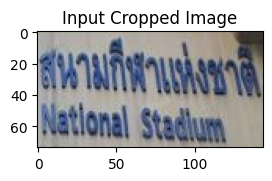

Predicted Station Name: National Stadium


In [13]:
# Test the SVC/LR/RF model with one image from the cropped test set
best_svc_lr_rf_model_path = os.path.join("models", "classical_machine_learning", "best_svc_model.pkl")
# best_svc_lr_rf_model_path = os.path.join("models", "classical_machine_learning", "best_lr_model.pkl")
# best_svc_lr_rf_model_path = os.path.join("models", "classical_machine_learning", "best_rf_model.pkl")
best_svc_lr_rf_model = joblib.load(best_svc_lr_rf_model_path)

# Load the image
input_crop_image_path = os.path.join("data", "outputs_multi_labels", "test", "crops", "National_Stadium", "crop_10.jpg")

input_crop_img = cv2.imread(input_crop_image_path)
# Convert the image to RGB
input_crop_image = cv2.cvtColor(input_crop_img, cv2.COLOR_BGR2RGB)

station_name = predict_svc_lr_rf_single_image(best_svc_lr_rf_model, vit_backbone, inference_transform, id2label, input_crop_image_path)

# Display the images
%matplotlib inline
plt.subplot(121)
plt.title('Input Cropped Image')
plt.imshow(input_crop_image)
plt.show()

if station_name:
    print(f"Predicted Station Name: {station_name}")
else:
    print("No station detected.")

In [ ]:
# Step B8: Train Support Vector Classifier Model, using HOG Features

# Define the list of hyperparameter for cross validation
svc_hog_param_grid = {
    'kernel': ['rbf'],  # Type of kernel
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient for ‘rbf’, ‘poly’, and ‘sigmoid’
    'tol': [1e-3, 1e-4]  # Tolerance for stopping criteria
}

best_svc_hog_model, svc_hog_cv_accuracy, svc_hog_test_accuracy = train_svc_hog(svc_X_train_full_scaled, svc_y_train_full, svc_X_test_scaled, svc_y_test, svc_hog_param_grid)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'C': 10, 'gamma': 'auto', 'kernel': 'rbf', 'tol': 0.001}
Best Cross-validation Accuracy: 0.571692
Test Accuracy: 0.618705
Classification Report:
                   precision    recall  f1-score   support

     Chong_Nonsi       0.30      0.50      0.38        48
National_Stadium       0.72      0.52      0.60       126
     Ratchadamri       0.67      0.56      0.61       108
     Saint_Louis       0.75      0.64      0.69        66
      Sala_Daeng       0.60      0.70      0.64       138
   Saphan_Taksin       0.61      0.79      0.69       120
            Siam       0.66      0.67      0.67       138
         Surasak       0.67      0.44      0.53        90

        accuracy                           0.62       834
       macro avg       0.62      0.60      0.60       834
    weighted avg       0.64      0.62      0.62       834

Confusion Matrix:
 [[24  1  2  4  4 12  0  1]
 [ 3 65  0  3 24 16 14 

c:\Users\beung-yoga\Documents\GitHub4\.venv\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


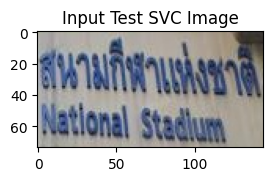

Predicted Station Name: National Stadium


In [14]:
# Test the SVC model with one image from the cropped test set
best_svc_hog_model_path = os.path.join("models", "classical_machine_learning", "best_svc_hog_model.pkl")
best_svc_hog_model = joblib.load(best_svc_hog_model_path)

# Load the image
input_test_svc_image_path = os.path.join("data", "outputs_multi_labels", "test", "crops", "National_Stadium", "crop_10.jpg")
input_test_svc_img = cv2.imread(input_test_svc_image_path)
# Convert the image to RGB
input_test_svc_image = cv2.cvtColor(input_test_svc_img, cv2.COLOR_BGR2RGB)

station_name = predict_svc_hog_single_image(best_svc_hog_model, input_test_svc_image)

# Display the images
%matplotlib inline
plt.subplot(121)
plt.title('Input Test SVC Image')
plt.imshow(input_test_svc_image)
plt.show()

if station_name:
    print(f"Predicted Station Name: {station_name}")
else:
    print("No station detected.")

In [ ]:
# Run this script in order to use the trained models for inference and evaluation

test_images_dir = os.path.join("data", "outputs_multi_labels", "test", "images")
yolo_model_multi_labels_path = os.path.join("models", "deep_learning_yolo_multi_labels", "best.pt")
yolo_model_single_label_path = os.path.join("models", "deep_learning_yolo_single_label", "best.pt")
device = "cuda"

best_yolo_model_multi_labels = YOLO(yolo_model_multi_labels_path)
best_yolo_model_single_label = YOLO(yolo_model_single_label_path)

inference_transform_path = os.path.join("models", "deep_learning_vit", "inference_transform.pkl")
inference_transform = joblib.load(inference_transform_path)

vit_model_path = os.path.join("models", "deep_learning_vit", "checkpoint-1990")
best_vit_model = ViTForImageClassification.from_pretrained(vit_model_path).to(device)
best_vit_model.eval()
vit_backbone = best_vit_model.vit

best_svc_model_path = os.path.join("models", "classical_machine_learning", "best_svc_model.pkl")
best_lr_model_path = os.path.join("models", "classical_machine_learning", "best_lr_model.pkl")
best_rf_model_path = os.path.join("models", "classical_machine_learning", "best_rf_model.pkl")
best_svc_hog_model_path = os.path.join("models", "classical_machine_learning", "best_svc_hog_model.pkl")

best_svc_model = joblib.load(best_svc_model_path)
best_lr_model = joblib.load(best_lr_model_path)
best_rf_model = joblib.load(best_rf_model_path)
best_svc_hog_model = joblib.load(best_svc_hog_model_path)

hog_scaler_path = os.path.join("models", "classical_machine_learning", "hog_scaler.pkl")
hog_scaler = joblib.load(hog_scaler_path)

id2label_path = os.path.join("models", "deep_learning_yolo_multi_labels", "id2label.pkl")
id2label = joblib.load(id2label_path)

c:\Users\beung-yoga\Documents\GitHub4\.venv\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
# Step B9: Reevaluate all models, using the same starting test set, for apple-to-apple comparison

test_images_dir = os.path.join("data", "outputs_multi_labels", "test", "images")

df_test_result = evaluate_test_set(
    best_yolo_model_multi_labels,
    best_yolo_model_single_label,
    test_images_dir,
    vit_backbone,
    inference_transform,
    best_vit_model,
    best_svc_model,
    best_lr_model,
    best_rf_model,
    best_svc_hog_model,
    hog_scaler,
    id2label,
    batch_size=16,
    device="cuda"
)


image 1/89 c:\Users\beung-yoga\Documents\GitHub4\final-project\data\outputs_multi_labels\test\images\Chong_Nonsi_008_png.rf.26cac58258259ef13c8bb8f661626130.jpg: 960x960 2 Chong Nonsis, 76.0ms
image 2/89 c:\Users\beung-yoga\Documents\GitHub4\final-project\data\outputs_multi_labels\test\images\Chong_Nonsi_015_png.rf.f17eca07d4a5017d63e1b304e8b54773.jpg: 960x960 2 Chong Nonsis, 15.1ms
image 3/89 c:\Users\beung-yoga\Documents\GitHub4\final-project\data\outputs_multi_labels\test\images\Chong_Nonsi_021_jpg.rf.3842ac4a52204ba533bec6ba81531293.jpg: 960x960 1 Chong Nonsi, 15.0ms
image 4/89 c:\Users\beung-yoga\Documents\GitHub4\final-project\data\outputs_multi_labels\test\images\Chong_Nonsi_029_png.rf.7bee8bfd972daec3e6ac2a379bd50013.jpg: 960x960 1 Saint Louis, 14.9ms
image 5/89 c:\Users\beung-yoga\Documents\GitHub4\final-project\data\outputs_multi_labels\test\images\Chong_Nonsi_043_png.rf.2d9c8b6ad1e6806441aeedee3a4ad7da.jpg: 960x960 1 Chong Nonsi, 14.9ms
image 6/89 c:\Users\beung-yoga\Docume


image 1/1 c:\Users\beung-yoga\Documents\GitHub4\final-project\data\outputs_multi_labels\test\images\National_Stadium_034_jpg.rf.f6e198b9505bcffb684803fe4871fb38.jpg: 960x960 1 National Stadium, 128.1ms
Speed: 7.0ms preprocess, 128.1ms inference, 2.3ms postprocess per image at shape (1, 3, 960, 960)
Results saved to data\pred_yolo_multi_labels

image 1/1 c:\Users\beung-yoga\Documents\GitHub4\final-project\data\outputs_multi_labels\test\images\National_Stadium_034_jpg.rf.f6e198b9505bcffb684803fe4871fb38.jpg: 960x960 1 signage, 89.8ms
Speed: 6.6ms preprocess, 89.8ms inference, 2.5ms postprocess per image at shape (1, 3, 960, 960)
Results saved to data\pred_yolo_single_label
Prediction:
YOLOv8: National Stadium
ViT Transformer: National Stadium
Support Vector Classifier: National Stadium
Logistic Regression: National Stadium
Random Forest: National Stadium
Support Vector Classifier + HOG: National Stadium


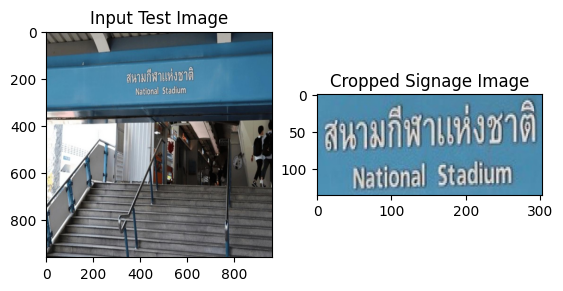

Predicted Station Names: National Stadium


In [35]:
# input_test_image_path = os.path.join("data", "outputs_multi_labels", "test", "images", "Siam_001_png.rf.ea48fca9fc87c689e62db2f87c4e9df4.jpg")
input_test_image_path = os.path.join("data", "outputs_multi_labels", "test", "images", "National_Stadium_034_jpg.rf.f6e198b9505bcffb684803fe4871fb38.jpg") # both detected
# input_test_image_path = os.path.join("data", "outputs_multi_labels", "test", "images", "Saphan_Taksin_036_png.rf.1be47567d2c64b4b0caa00619d6c3b6f.jpg") # both NOT detected
# input_test_image_path = os.path.join("data", "outputs_multi_labels", "test", "images", "Saint_Louis_014_png.rf.675210ec5c7e63f294f04234c94b3589.jpg") # single label detected; multiple labels NOT detected
# input_test_image_path = os.path.join("data", "outputs_multi_labels", "test", "images", "Siam_057_png.rf.2de24e4b82d7baabef7861eef1a6f1b2.jpg") # multiple labels detected; single label NOT detected;

input_test_img = cv2.imread(input_test_image_path)
# Convert the image to RGB
input_test_image = cv2.cvtColor(input_test_img, cv2.COLOR_BGR2RGB)

new_resulting_image_path = None

new_resulting_image_path, cropped_image_path, yolo_pred, vit_pred, svc_pred, lr_pred, rf_pred, svc_hog_pred = predict_single_image(best_yolo_model_multi_labels, best_yolo_model_single_label, best_vit_model, best_svc_model, best_lr_model, best_rf_model, best_svc_hog_model, vit_backbone, inference_transform, id2label, input_test_image_path)

# Display the images
%matplotlib inline
plt.subplot(121)
plt.title('Input Test Image')
plt.imshow(input_test_image)
if new_resulting_image_path != None:
    output_image_path = os.path.join(new_resulting_image_path)
    output_img = cv2.imread(output_image_path)
    # Convert the image to RGB
    output_image = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
    plt.subplot(122)
    plt.title('Cropped Signage Image')
    plt.imshow(output_image)
plt.show()

if svc_pred:
    print(f"Predicted Station Names: {svc_pred}")
else:
    print("No station detected.")

In [28]:
# Step B10: Evaluate naive model with option 1 
# Always predicts 'Siam', which has the highest ridership, according to the statistics from BTS, the metro operator.
naive_1_accuracy = predict_naive_evaluate_test_set(1, svc_y_train_full, svc_y_test)

Test Accuracy: 0.165468
Classification Report:
                   precision    recall  f1-score   support

     Chong_Nonsi       0.00      0.00      0.00        48
National_Stadium       0.00      0.00      0.00       126
     Ratchadamri       0.00      0.00      0.00       108
     Saint_Louis       0.00      0.00      0.00        66
      Sala_Daeng       0.00      0.00      0.00       138
   Saphan_Taksin       0.00      0.00      0.00       120
            Siam       0.17      1.00      0.28       138
         Surasak       0.00      0.00      0.00        90

        accuracy                           0.17       834
       macro avg       0.02      0.12      0.04       834
    weighted avg       0.03      0.17      0.05       834

Confusion Matrix:
 [[  0   0   0   0   0   0  48   0]
 [  0   0   0   0   0   0 126   0]
 [  0   0   0   0   0   0 108   0]
 [  0   0   0   0   0   0  66   0]
 [  0   0   0   0   0   0 138   0]
 [  0   0   0   0   0   0 120   0]
 [  0   0   0   0   0   

In [29]:
# Step B11: Evaluate naive model with option 2
# Randomly predicts one of the 8 stations, based on the frequency of the stations in the training set.
naive_2_accuracy = predict_naive_evaluate_test_set(2, svc_y_train_full, svc_y_test)

Station Frequency Distribution:

  Chong_Nonsi: 8.00%
  National_Stadium: 15.32%
  Ratchadamri: 11.45%
  Saint_Louis: 9.01%
  Sala_Daeng: 16.16%
  Saphan_Taksin: 14.98%
  Siam: 15.66%
  Surasak: 9.43%

Test Accuracy: 0.129496
Classification Report:
                   precision    recall  f1-score   support

     Chong_Nonsi       0.08      0.10      0.09        48
National_Stadium       0.14      0.15      0.14       126
     Ratchadamri       0.14      0.12      0.13       108
     Saint_Louis       0.10      0.11      0.10        66
      Sala_Daeng       0.15      0.14      0.15       138
   Saphan_Taksin       0.12      0.12      0.12       120
            Siam       0.14      0.13      0.13       138
         Surasak       0.13      0.12      0.13        90

        accuracy                           0.13       834
       macro avg       0.12      0.13      0.12       834
    weighted avg       0.13      0.13      0.13       834

Confusion Matrix:
 [[ 5 10  6  3  8  7  4  5]
 [13 